In [1]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2-160.tgz
!tar -xzf /content/imagewoof2-160.tgz

--2022-07-28 15:41:42--  https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2-160.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.203.224
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.203.224|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92612825 (88M) [application/x-tar]
Saving to: ‘imagewoof2-160.tgz’

imagewoof2-160.tgz  100%[===================>]  88.32M  13.5MB/s    in 7.9s    

2022-07-28 15:41:51 (11.1 MB/s) - ‘imagewoof2-160.tgz’ saved [92612825/92612825]



In [2]:
import os
import json

import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models
import torchvision
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [3]:
classes = ['Shih-Tzu', 'Rhodesian ridgeback', 'Beagle', 'English foxhound', 'Border terrier', 'Australian terrier', 
           'Golden retriever', 'Old English sheepdog', 'Samoyed', 'Dingo']

In [4]:
train_directory = '/content/imagewoof2-160/train'
test_directory = '/content/imagewoof2-160/val'
data_dir = '/content/imagewoof2-160'

print(os.listdir(data_dir))

['val', 'train', 'noisy_imagewoof.csv']


In [5]:
train_tfms = tt.Compose([tt.RandomCrop(160), 
                         tt.ToTensor()])

test_tfms = tt.Compose([tt.RandomCrop(160), 
                         tt.ToTensor()])

In [6]:
train_ds = ImageFolder(data_dir + '/train', train_tfms)
val_ds = ImageFolder(data_dir + '/val', test_tfms)

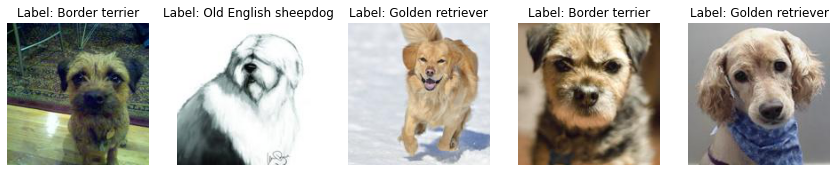

In [8]:
def visualize_samples(n, title=None, count=10):
    # visualize random n samples
    indices = np.random.choice(np.arange(len(train_ds)), n, replace=False)
    plt.figure(figsize=(count*3,3))
    display_indices = indices[:count]
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))        
    for i, j in enumerate(indices):    
        img, label = train_ds[j]
        plt.subplot(1,count,i+1)
        plt.title("Label: %s" %  classes[label])
        plt.imshow(img.permute(1, 2, 0))
        plt.grid(False)
        plt.axis('off')
 
visualize_samples(n=5)

In [9]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers= 8, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, num_workers=8, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [16]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [17]:
device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [ ]:
# Load pre-trained ResNet18 and replace the last fully-connected layer
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(classes))

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_fe = optim.SGD(model.fc.parameters(), lr=1e-2, momentum=0.9)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
def accuracy(preds, labels):
    preds = torch.argmax(preds, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def evaluate(model, criterion, val_loader):
    model.eval()
    loss, acc = [], []
    for images, labels in val_loader:
        preds = model(images)
        loss.append(criterion(preds, labels).detach())
        acc.append(accuracy(preds, labels))
    return {'val_loss': torch.stack(loss).mean().item(), 
            'val_acc': torch.stack(acc).mean().item()}

In [ ]:
def fit(epochs, model, train_loader, val_loader, criterion, optimizer):
    history = []
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        train_acc = []

        for images, labels in train_loader:
            optimizer.zero_grad()
            preds = model(images)
            loss = criterion(preds, labels)
            train_losses.append(loss)
            train_acc.append(accuracy(preds, labels))
            loss.backward()
            optimizer.step()

        # Validation phase
        result = evaluate(model, criterion, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_acc).mean().item()
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))
        history.append(result)
    return history

num_epochs = 20

history_fe = fit(num_epochs, model, train_dl, val_dl, criterion, optimizer_fe)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.6716, train_acc: 0.7737, val_loss: 0.7738, val_acc: 0.7480
Epoch [1], train_loss: 0.5660, train_acc: 0.8225, val_loss: 0.8030, val_acc: 0.7713
Epoch [2], train_loss: 0.5099, train_acc: 0.8406, val_loss: 0.6273, val_acc: 0.8163
Epoch [3], train_loss: 0.5410, train_acc: 0.8425, val_loss: 0.5152, val_acc: 0.8433
Epoch [4], train_loss: 0.5089, train_acc: 0.8454, val_loss: 0.7625, val_acc: 0.7770
Epoch [5], train_loss: 0.5102, train_acc: 0.8513, val_loss: 0.6058, val_acc: 0.8262
Epoch [6], train_loss: 0.4419, train_acc: 0.8577, val_loss: 0.5668, val_acc: 0.8290
Epoch [7], train_loss: 0.4805, train_acc: 0.8596, val_loss: 0.6139, val_acc: 0.8122
Epoch [8], train_loss: 0.5099, train_acc: 0.8554, val_loss: 0.5446, val_acc: 0.8478
Epoch [9], train_loss: 0.4683, train_acc: 0.8561, val_loss: 0.6386, val_acc: 0.8223
Epoch [10], train_loss: 0.4750, train_acc: 0.8605, val_loss: 0.5540, val_acc: 0.8384
Epoch [11], train_loss: 0.4239, train_acc: 0.8688, val_loss: 0.5665, val_ac

In [ ]:
def plot_accuracies(history):
  train_acc = [x.get('train_acc') for x in history]
  val_acc = [x['val_acc'] for x in history]
  plt.plot(train_acc, '-bx')
  plt.plot(val_acc, '-rx')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend(['Training','Validation'])
  plt.title('Accuracy vs No. of epoch')

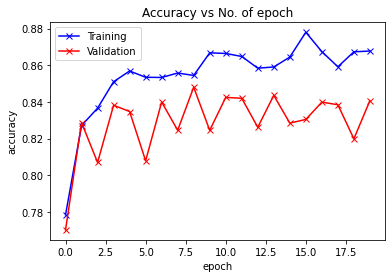

In [ ]:
plot_accuracies(history_fe)

In [ ]:
torch.save(model, 'model.pth')

In [ ]:
def predict_image(img, model):
  # Convert to a batch of 1
  img_gpu = to_device(img.unsqueeze(0),device)
  y = model(img_gpu)
  # Pick index with highest probability
  _, preds = torch.max(y, dim = 1)
  # Retrieve the class label
  return classes[preds[0].item()]

Label: Dingo , Predicted: Dingo


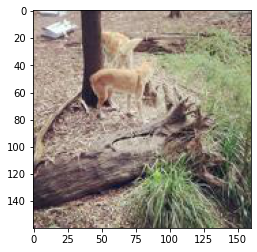

In [ ]:
img, label = val_ds[3765]
plt.imshow(img.permute(1,2,0))
print("Label:", classes[label], ', Predicted:', predict_image(img, model))

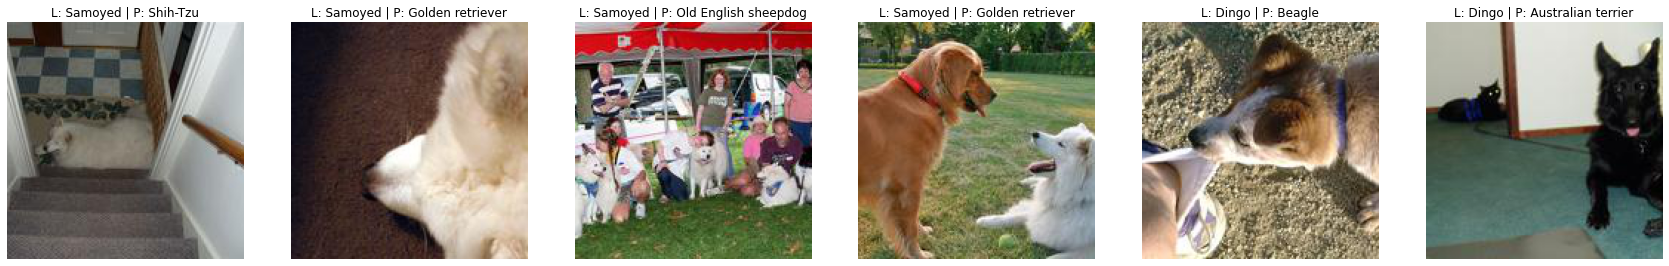

In [ ]:
def err(count=10, title=None):
    plt.figure(figsize=(count*5,6))
    if title:
        plt.suptitle("%s %s/%s" % (title, 10, 5))
    c = 0        
    for i in range(3500, 3600): 
        
        img, label = val_ds[i]
        if classes[label] != predict_image(img, model):
            if c == 6:
                break 
            plt.subplot(1,count,c+1)
            plt.title("L: %s | P: %s" %  (classes[label], predict_image(img, model)))
            
            plt.imshow(img.permute(1, 2, 0))
            plt.grid(False)
            plt.axis('off')
            c+=1
err()

In [53]:
y_true = []
y_pred = []
 
for data in tqdm(val_dl):
  images,labels=data[0].to(device),data[1]  
  y_true.extend(labels.cpu().numpy())
 
  outputs=model(images)
 
  _, predicted = torch.max(outputs, 1)
  y_pred.extend(predicted.cpu().numpy())

  0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 62/62 [00:05<00:00, 11.46it/s]


In [56]:
cf_matrix = confusion_matrix(y_true, y_pred)
df = pd.DataFrame(cf_matrix, index=classes, columns=classes)

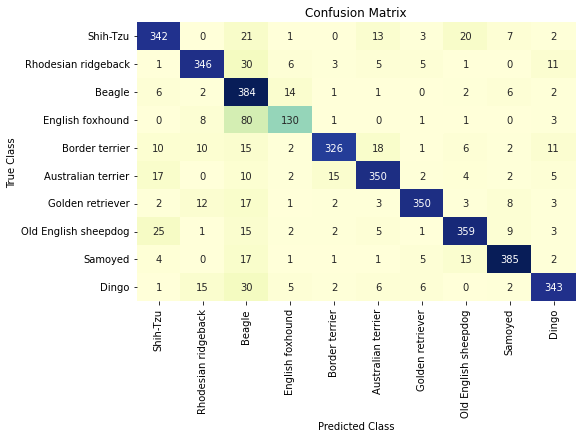

In [62]:
plt.figure(figsize=(8, 6))
sns.heatmap(df, annot=True, cbar=None,cmap="YlGnBu",fmt="d")
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), 
plt.xlabel("Predicted Class")
plt.show()